## Introduction

### In this notebook we use [DeepLabV3+](https://arxiv.org/abs/1802.02611) for Road Extraction from Satellite Imagery using [DeepGlobe Road Extraction Dataset](https://www.kaggle.com/balraj98/deepglobe-road-extraction-dataset).

In [ ]:
# モジュールを最新にする
! pip install --upgrade gdown

# ここでランタイムを再起動

In [ ]:
import gdown

# a file
url = "https://drive.google.com/file/d/1gBG7SxMHnD32ExU9oEBwEK1M6HdihDpP/view?usp=sharing"
output1 = "./deeplab.zip"
gdown.download(url, output1, quiet=False, fuzzy=True)
print("Download deeplab.zip")
!7z x ./deeplab.zip
# !mv ./labro_tomato ../
print("Extend deeplab.zip")

Downloading...
From: https://drive.google.com/uc?id=1wm3yH5R1NJjjjtqhJosgANiKSU63-Jai
To: /content/deeplab.zip
100%|██████████| 40.9M/40.9M [00:01<00:00, 36.7MB/s]


Download deeplab.zip

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./            1 file, 40945708 bytes (40 MiB)

Extracting archive: ./deeplab.zip
--
Path = ./deeplab.zip
Type = zip
Physical Size = 40945708

  0%     52% 46 - deeplab/data/annotation/laboromask/laboromask.zip                                                            68% 548 - deeplab/data/annotation/laboromask/masks/IMG_20191215_111409.png                                                                            80% 969 - __MACOSX/

In [ ]:
# !pip install -U albumentations
!pip install "opencv-python-headless<4.3"
# !pip install "opencv-python-headless<3.9"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully uninstalled opencv-python-headless-4.7.0.68


In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
import os
import requests
import numpy as np
from PIL import Image
import imageio
from sklearn import model_selection
import cv2

from pycocotools.coco import COCO
from tqdm import tqdm

segmask = ''
MASK_PATH = './deeplab/data/annotation/laboromask/masks'


JSON_PATH = './deeplab/data/annotation/laboromask/output.json'

SEG_PATH_FULL = './deeplab/data/segmentation_full'

os.makedirs(SEG_PATH_FULL, exist_ok=True)
os.makedirs(os.path.join(SEG_PATH_FULL, 'images'), exist_ok=True)
os.makedirs(os.path.join(SEG_PATH_FULL, 'masks'), exist_ok=True)

def process_data(images, segmask, batch_size=8, data_type="train"):
    os.makedirs(os.path.join(SEG_PATH_FULL, f'images/{data_type}/'), exist_ok=True)
    os.makedirs(os.path.join(SEG_PATH_FULL, f'masks/{data_type}/'), exist_ok=True)
    
    for im in tqdm(images, total=len(images)):

        img = imageio.imread(im['darwin_url'])
        
        # print(img.shape, 'image shape')
        if img.shape[2]==4:
            img = img[:, :, :-1]
            
        annIds = coco.getAnnIds(imgIds=[im['id']])
        anns = coco.loadAnns(annIds)
        
        image_name = im['file_name']
        extension = image_name.split('.')[-1]
        filename = image_name.replace(extension, "png")
        width = im['width']
        height = im['height']
        
        mask_all = imageio.imread(f'{MASK_PATH}/{filename}')
        
        if mask_all.shape[2]==4:
            mask_all = mask_all[:,:,:-1]
            
        #save images
        imageio.imwrite(os.path.join(SEG_PATH_FULL, f'images/{data_type}/{filename}'), img.astype(np.uint8))
        #save masks
        imageio.imwrite(os.path.join(SEG_PATH_FULL, f'masks/{data_type}/{filename}'), mask_all.astype(np.uint8))
   
if __name__ == "__main__":
    coco = COCO(JSON_PATH)
    print(coco.info)
    
    # # get all category names
    # cats = coco.loadCats(coco.getCatIds())
    # cats = [cat['name'] for cat in cats]
    
    # get all ImgIds and images
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)

    # batch size
    batch_size = 4
    
    train, test = model_selection.train_test_split(
        images,
        # train_size=len(images)//5*4,
        # test_size=len(images)//5*1,
        train_size=16,
        test_size=4,
        random_state=42  
    )

    test, valid = model_selection.train_test_split(
        test,
        train_size=len(test)//2,
        test_size=len(test)//2,
        random_state=42  
    )


    process_data(train, batch_size, data_type="train")
    process_data(valid, batch_size, data_type="validation")
    process_data(test, batch_size, data_type="test")

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
<bound method COCO.info of <pycocotools.coco.COCO object at 0x7f8a4cde6a30>>


100%|██████████| 2/2 [00:59<00:00, 29.67s/it]


### Libraries 📚⬇

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
import segmentation_models_pytorch as smp

### Read Data & Create train / valid splits 📁

In [ ]:
DATA_DIR = '/content/deeplab/data/annotation/laboromask'

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_mapping.csv'))
# Get class names
class_names = class_dict['class_name'].tolist()
# Get class RGB values
# class_rgb_values = class_dict[['r','g','b']].values.tolist()
class_rgb_values = class_dict[['class_color']].values.tolist()
tmp_list =[]
for i in class_rgb_values:
    list_ = i[0].split(' ')
    for j in range(len(list_)):
        list_[j] = int(list_[j])
    tmp_list.append(list_)
class_rgb_values = tmp_list
print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['__background__', 'b_fully_ripened', 'b_green', 'b_half_ripened', 'l_fully_ripened', 'l_green', 'l_half_ripened']
Class RGB values:  [[0, 0, 0], [255, 50, 50], [255, 225, 50], [109, 255, 50], [50, 255, 167], [50, 167, 255], [109, 50, 255]]


#### Shortlist specific classes to segment

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['__background__', 'b_fully_ripened', 'b_green', 'b_half_ripened', 'l_fully_ripened', 'l_green', 'l_half_ripened']
# select_classes = ['__background__', 'soyleaf']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['__background__', 'b_fully_ripened', 'b_green', 'b_half_ripened', 'l_fully_ripened', 'l_green', 'l_half_ripened']
Class RGB values:  [[0, 0, 0], [255, 50, 50], [255, 225, 50], [109, 255, 50], [50, 255, 167], [50, 167, 255], [109, 50, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:

from torchvision import  transforms

class TomatoDataset(torch.utils.data.Dataset):

    """DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            img_dir,
            mask_dir,
            data_type="train",
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
            size=1024,
    ):
        
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_paths = os.listdir(f'{img_dir}/{data_type}')
        # self.mask_paths = os.listdir(f'{mask_dir}/{data_type}')
        self.data_type = data_type
        self.size = size
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(f'{self.img_dir}/{self.data_type}/{self.image_paths[i]}'), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(f'{self.mask_dir}/{self.image_paths[i]}'), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(f'{self.mask_dir}/{self.data_type}/{self.image_paths[i]}'), cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, dsize=(self.size, self.size))
        # mask = cv2.resize(mask, dsize=(self.size, self.size))
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

In [ ]:
# img_dir = '/content/deeplab/data/segmentation_full/images/'
# mask_dir = '/content/deeplab/data/annotation/semanticmask/masks/'

img_dir = '/content/deeplab/data/segmentation_full/images/'
mask_dir = '/content/deeplab/data/segmentation_full/masks/'

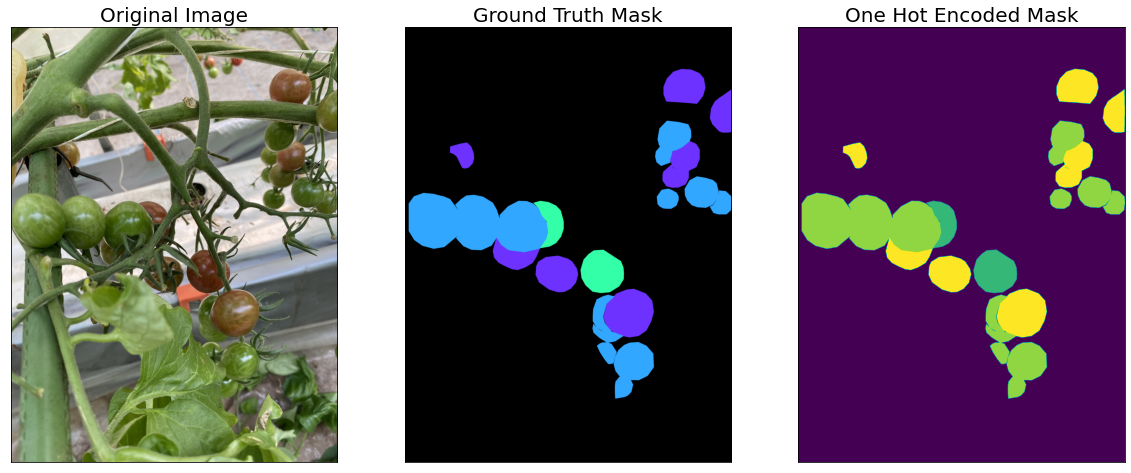

In [ ]:
dataset = TomatoDataset(img_dir, mask_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [ ]:
def get_training_augmentation():
    train_transform = [   
        
        album.RandomCrop(height=1024, width=1024, always_apply=True),
        
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        # album.Resize(256,256),
        
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        
        album.RandomCrop(height=2048, width=1024, always_apply=True),
    ]
    return album.Compose(test_transform)


def get_prediction_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        
        album.PadIfNeeded(min_height=1024, min_width=256, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

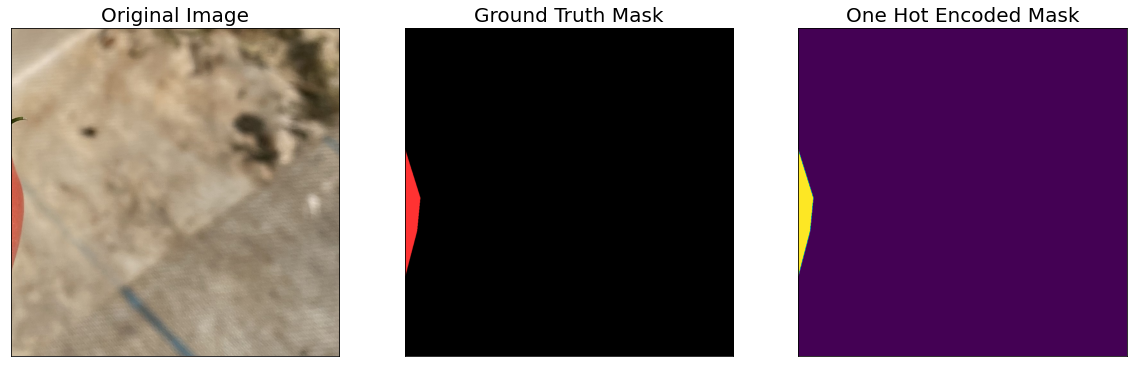

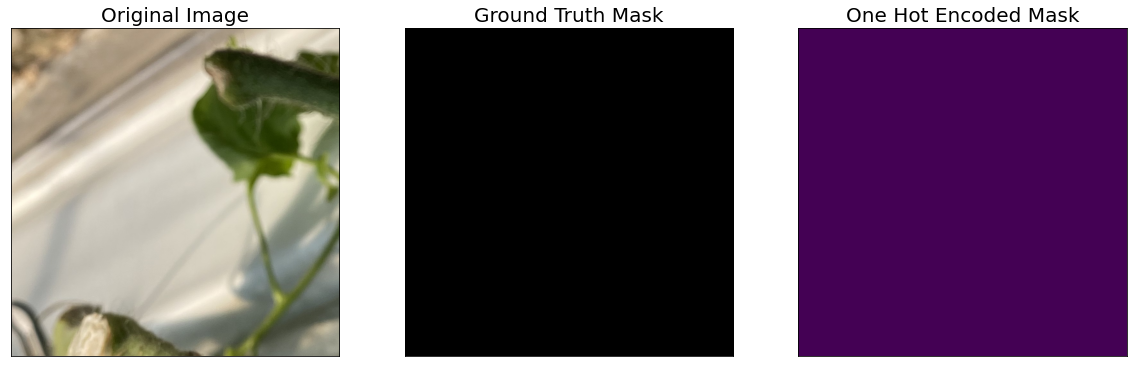

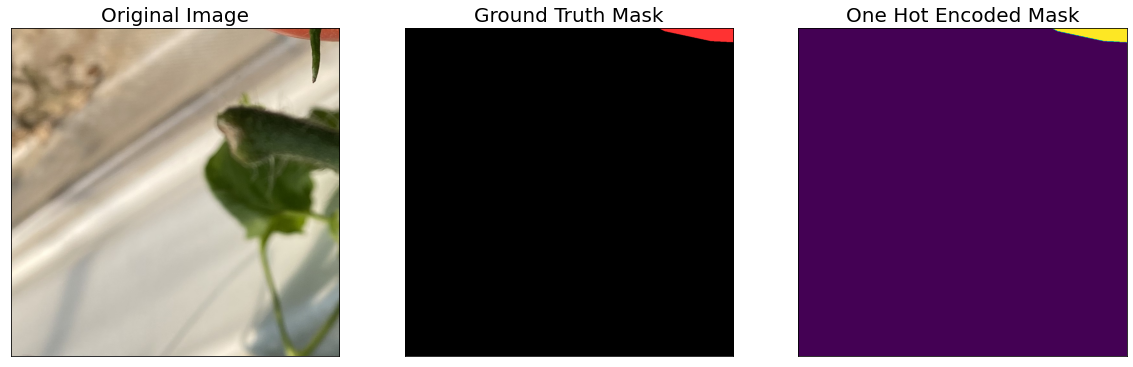

In [ ]:
augmented_dataset = TomatoDataset(
    img_dir,
    mask_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training DeepLabV3+

<h3><center>DeepLabV3+ Model Architecture</center></h3>
<img src="https://miro.medium.com/max/1000/1*2mYfKnsX1IqCCSItxpXSGA.png" width="750" height="750"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/abs/1802.02611">Image Source: DeepLabV3+ [Liang-Chieh Chen et al.]</a></center></h4>

### Model Definition

In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

#### Get Train / Val DataLoaders

In [ ]:
class_names

['__background__',
 'b_fully_ripened',
 'b_green',
 'b_half_ripened',
 'l_fully_ripened',
 'l_green',
 'l_half_ripened']

In [ ]:
# Get train and val dataset instances
train_dataset = TomatoDataset(
    img_dir,
    mask_dir,
    data_type="train",
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = TomatoDataset(
    img_dir,
    mask_dir,
    data_type="validation",
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

#### Set Hyperparams

In [ ]:
from segmentation_models_pytorch import utils
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

lr = 0.002

# Set num of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
# loss = smp.utils.losses.DiceLoss()
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/deeplab/data/best_model.pth'):
    model = torch.load('/content/deeplab/data/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training DeepLabV3+

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:06<00:00,  3.34s/it, dice_loss - 0.7767, iou_score - 0.1872]
Model saved!

Epoch: 1
train:   0%|          | 0/8 [00:29<?, ?it/s]


RuntimeError: ignored

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('/content/best_model.pth'):
    best_model = torch.load('/content/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


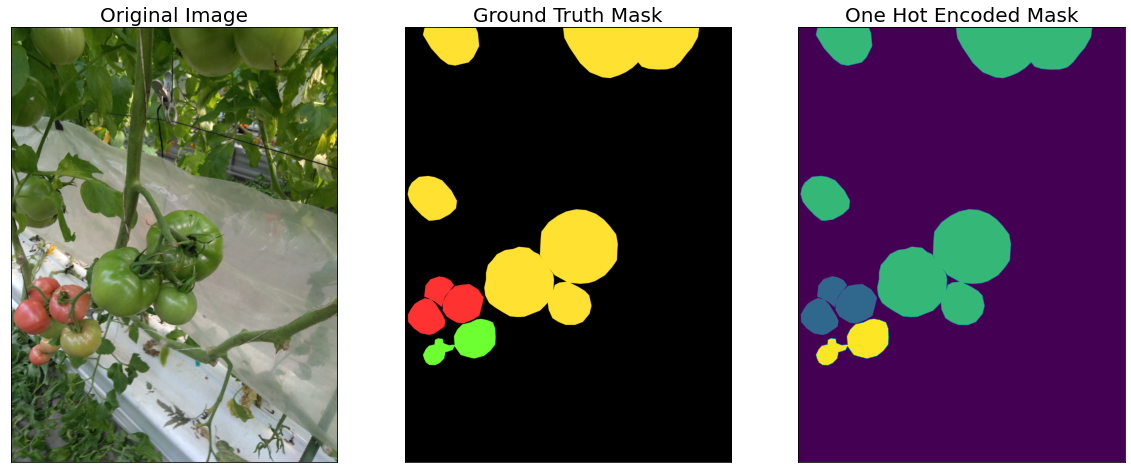

In [ ]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = TomatoDataset(
    img_dir,
    mask_dir,
    data_type="test",
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = TomatoDataset(
    img_dir,
    mask_dir,
    data_type="test",
    # augmentation=get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_max=image.shape[2]
    x_min=0
    y_max=image.shape[1]
    y_min=0
    # 画像を分割してpredict。その後結合して元の大きさに戻す
    crop_size_x = 1024
    crop_size_y = 1024
    crop_step = int(crop_size_x/2)
    if ((x_max-x_min)//crop_size_x)==0:
        x_max = x_min+1024

    if ((y_max-y_min)//crop_size_y)==0:
        y_max = y_min+1024

    dst_ = image
    all_pred_mask = []
    all_image_vis = []
    all_pred_building_heatmap = []
    all_one_hot = []

    for j in range((dst_.shape[2]//crop_step)):
        x_min_ = crop_step*j
        x_max_ = crop_step*j+crop_size_x
        if x_max_>(x_max-x_min):
            x_min_ = dst_.shape[2]-crop_size_x
            x_max_ = dst_.shape[2]
        pred_mask_y = []
        image_vis_y = []
        pred_building_heatmap_y = []
        one_hot_y = []

        for i in range((dst_.shape[1]//crop_size_y)+1):
            y_max_ = crop_size_y*(i+1)
            y_min_ = crop_size_y*i
            if y_max_>(y_max-y_min):
                y_max_ = dst_.shape[1]
                y_min_ = dst_.shape[1]-crop_size_y
            crop_img = dst_[:, y_min_:y_max_,x_min_:x_max_]
            crop_img = crop_img[:,:,:]
            if crop_img.shape[0]==4:
                crop_img = crop_img[:,:,:-1]

            x_tensor = torch.from_numpy(crop_img).to(DEVICE).unsqueeze(0)
            # Predict test image
            pred_mask = best_model(x_tensor)
            pred_mask = pred_mask.detach().squeeze().cpu().numpy()
            # Convert pred_mask from `CHW` format to `HWC` format
            pred_mask = np.transpose(pred_mask,(1,2,0))
            
            one_hot = reverse_one_hot(pred_mask)
            # print('one hot', one_hot)
            # Get prediction channel corresponding to building
            pred_building_heatmap = pred_mask[:,:,select_classes.index('b_fully_ripened')]
            # pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
            pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
            pred_mask_y.append(pred_mask)
            image_vis_y.append(image_vis)
            pred_building_heatmap_y.append(pred_building_heatmap)
            one_hot_y.append(one_hot)
        # print('pred_mask_y', len(pred_mask_y))

        if len(pred_mask_y)*crop_size_y>(y_max-y_min):
            start_y = len(pred_mask_y)*crop_size_y - (y_max-y_min)
            pred_mask_y_ = np.vstack(pred_mask_y[:-1])
            image_vis_y_ = np.vstack(image_vis_y[:-1])
            pred_building_heatmap_y_ = np.vstack(pred_building_heatmap_y[:-1])
            one_hot_y_ = np.vstack(one_hot_y[:-1])

            pred_mask_y = np.vstack((pred_mask_y_, pred_mask_y[-1][start_y:]))
            image_vis_y = np.vstack((image_vis_y_, image_vis_y[-1][start_y:]))
            pred_building_heatmap_y = np.vstack((pred_building_heatmap_y_, pred_building_heatmap_y[-1][start_y:]))
            one_hot_y = np.vstack((one_hot_y_, one_hot_y[-1][start_y:]))
        else:
            pred_mask_y = np.vstack(pred_mask_y)
            image_vis_y = np.vstack(image_vis_y)
            pred_building_heatmap_y = np.vstack(pred_building_heatmap_y)
            one_hot_y = np.vstack(one_hot_y)
   
        all_pred_mask.append(pred_mask_y)
        all_image_vis.append(image_vis_y)
        all_pred_building_heatmap.append(pred_building_heatmap_y)
        all_one_hot.append(one_hot_y)
        # print('all pred mask len', len(all_pred_mask))

    # if len(all_pred_mask)*crop_step>(x_max-x_min):
    crop_x_start = int(crop_step/2)
    crop_x_end = int(crop_step+crop_step/2)
    start_x = len(all_pred_mask)*crop_step - (x_max-x_min) - crop_x_start
    if len(all_pred_mask)>2 :
        all_pred_mask_ = [p_mask_[:,crop_x_start:crop_x_end] for p_mask_ in all_pred_mask[1:-1]]
        all_image_vis_ = [p_mask_[:,crop_x_start:crop_x_end] for p_mask_ in all_image_vis[1:-1]]
        all_pred_building_heatmap_ =[p_mask_[:,crop_x_start:crop_x_end] for p_mask_ in all_pred_building_heatmap[1:-1]]
        all_one_hot_ = [p_mask_[:,crop_x_start:crop_x_end] for p_mask_ in all_one_hot[1:-1]]

        all_pred_mask_ = np.hstack(all_pred_mask_)
        all_image_vis_ = np.hstack(all_image_vis_)
        all_pred_building_heatmap_ = np.hstack(all_pred_building_heatmap_)
        all_one_hot_ = np.hstack(all_one_hot_)

        all_pred_mask = np.hstack((all_pred_mask[0][:,:crop_x_end], all_pred_mask_, all_pred_mask[-1][:,start_x:]))
        all_image_vis = np.hstack((all_image_vis[0][:,:crop_x_end], all_image_vis_, all_image_vis[-1][:,start_x:]))
        all_pred_building_heatmap = np.hstack((all_pred_building_heatmap[0][:,:crop_x_end], all_pred_building_heatmap_, all_pred_building_heatmap[-1][:,start_x:]))
        all_one_hot = np.hstack((all_one_hot[0][:,:crop_x_end], all_one_hot_, all_one_hot[-1][:,start_x:]))
    else:
        all_pred_mask = np.hstack((all_pred_mask[0][:,:crop_x_end], all_pred_mask[-1][:,start_x:]))
        all_image_vis = np.hstack((all_image_vis[0][:,:crop_x_end], all_image_vis[-1][:,start_x:]))
        all_pred_building_heatmap = np.hstack((all_pred_building_heatmap[0][:,:crop_x_end], all_pred_building_heatmap[-1][:,start_x:]))
        all_one_hot = np.hstack((all_one_hot[0][:,:crop_x_end], all_one_hot[-1][:,start_x:]))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    print(image_vis.shape, gt_mask.shape, all_pred_mask.shape)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, all_pred_mask])) 

    visualize(
        original_image = image_vis,
        predicted_mask = all_pred_mask,
        predicted_building_heatmap = all_pred_building_heatmap,
        one_hot = all_one_hot
    )


### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()